<a href="https://colab.research.google.com/github/YunfanXu/Detection-of-Manipulated-Facial-Video/blob/main/Detect_Manipulated_Facial_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of Manipulated Facial Video
##### Inspired from : https://arxiv.org/abs/1901.08971v1
##### Team members:
Huan Wang(hw2588) & Yunfan Xu(yx2277)


## Introduction:
#####  Manipulated videos, audio and images have been around for years, but the rise of deep learning and artificial intelligence have made them harder to detect. The misinformation created by Deepfakes, FaceSwap and Face2face can easily misdirect people and intensify social conflicts *(Fridrich, J., & Kodovsky, J. (2012). Rich Models for Steganalysis of Digital Images. IEEE Transactions on Information Forensics and Security, 7(3), 868-882. doi:10.1109/tifs.2012.2190402)*. The spread of manipulated facial videos and images on social media networks encourages sociality to seriously consider its dangers and encourages researchers to develop powerful deepfake detection methods. <br>

Since there is a large amount of active research in video/image generation and manipulation that is constantly developing, it becomes difficult for people to tell the real information in their daily life which will lead to a decline in people’s trust in digital content. The spreading of fake news and information might even cause further social pandemic and instability. 


### Issues

A realistic-looking video that seemed to show former President Barack Obama cussing and calling President Donald Trump a "total and complete dips---," went viral on Tuesday, bringing attention to the dangers of a controversial video-editing technology that many have called "the future of fake news."



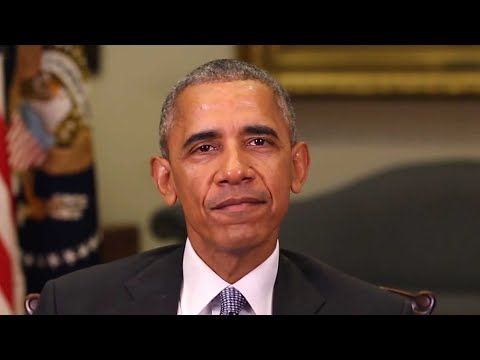

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('cQ54GDm1eL0') #Reference:https://www.youtube.com/watch?v=cQ54GDm1eL0

### Objective

#### We need to build a model such that it should recognize whether the given video(or  image sequence) is  fake or real. 

### Data Background

#### In our project, we choose to use FaceForensics++ (http://niessnerlab.org/) as our dataset. FaceForensics++ dataset collected by Visual Computing Group: a database containing more than 1.8 million images from 4000 fake videos - an order of magnitude more than existing datasets. 

These fake videos actually derived from 1000 video sequences containing 509,914 images downloaded from the Internet, which were used as our pristine data. We got the dataset after using the three different manipulation methods(Face2Face, DeepFakes, and FaceSwap) on them. 

The Faceforensics++ data was collected by Visual Computing Group  , one can obtain this data on accepting their terms and conditions. To download and extract the data please visit https://github.com/ondyari/FaceForensics
<br>
To get more understanding please visit https://arxiv.org/pdf/1901.08971v1.pdf 

## Data Gathering and Preprocessing
In our experiment, we downloaded a total of 100 raw videos, 100 high quality videos, and 100 low quality videos. In each quality level video, it contains 49 real videos and 51 manipulated videos which consists of 17 DeepFakes videos, 17 FaceSwap videos, and 18 Face2Face videos. Then, from Table 1, we split each quality level video dataset into a fixed training, validation, and test set, consisting of 75, 5, and 20 videos respectively. 

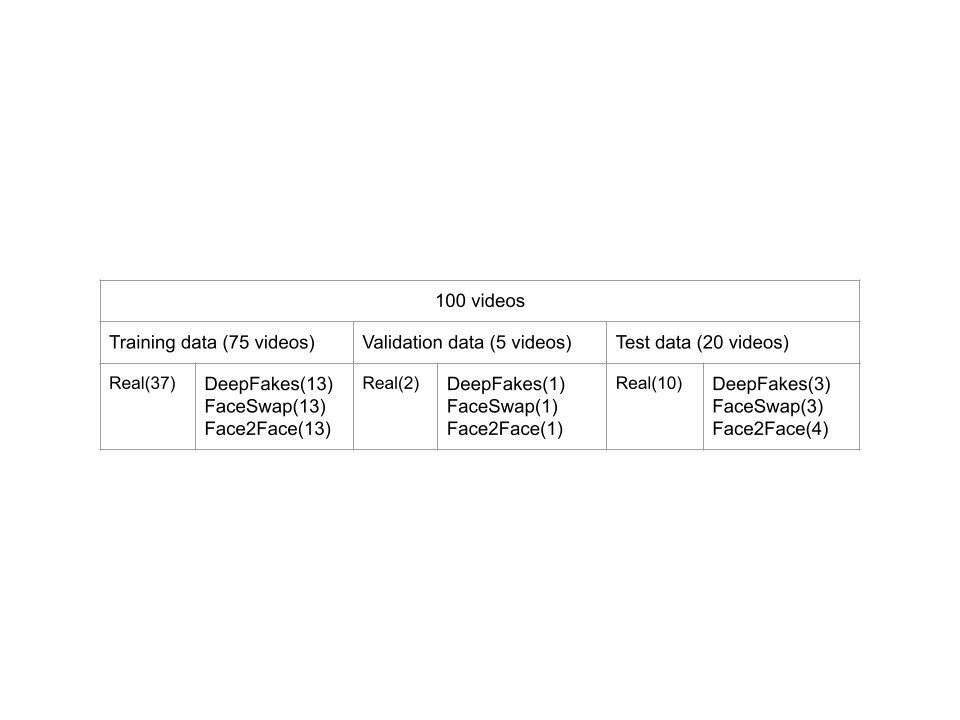

### Download the dataset from FaceForensics++

In [ ]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

In [ ]:
# In order to avoid downloading videos everytime.
# We can connect to personal drive and store the videos in it. 

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!/usr/bin/env python
""" Downloads FaceForensics++ and Deep Fake Detection public data release
Example usage:
    see -h or https://github.com/ondyari/FaceForensics
"""
# -*- coding: utf-8 -*-
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join


# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original': 'original_sequences/youtube',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
    }
    # ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
    #             'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
    #             'NeuralTextures']
ALL_DATASETS = ['original', 'Deepfakes',
                 'Face2Face', 'FaceSwap']
                
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-c', '--compression', type=str, default='c23',
                        help='Which compression degree. All videos '
                             'have been generated with h264 with a varying '
                             'codec. Raw (c0) videos are lossless compressed.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type, i.e. videos, masks, for our '
                             'manipulation methods, models, for Deepfakes.',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=10,
                        help='Select a number of videos number to '
                             "download if you don't want to download the full"
                             ' dataset.')
    parser.add_argument('--server', type=str, default='CA',
                        help='Server to download the data from. If you '
                             'encounter a slow download speed, consider '
                             'changing the server.',
                        choices=SERVERS
                        )
    args = parser.parse_args(['/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/dataset','-c','c23','-t','videos','-n','100','--server','EU'])
    print("------------")

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        if report_progress:
            urllib.request.urlretrieve(url, out_file_tmp,
                                       reporthook=reporthook)
        else:
            urllib.request.urlretrieve(url, out_file_tmp)
        os.rename(out_file_tmp, out_file)
    else:
        tqdm.write('WARNING: skipping download of existing file ' + out_file)


def main(args):
    # TOS
    print('By pressing any key to continue you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')
    print('Press any key to continue, or CTRL-C to exit.')
    _ = input('')

    # Extract arguments
    c_datasets = ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            # Here we download the original youtube videos zip file
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
            	suffix = 'info'
            download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists and video lenghts list from server
        if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
        	filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
        	if 'actors' in dataset_path:
        		filelist = filepaths['actors']
        	else:
        		filelist = filepaths['DeepFakesDetection']
        elif 'original' in dataset_path:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            filelist = []
            for pair in file_pairs:
            	filelist += pair
        else:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            # Get filelist
            filelist = []
            for pair in file_pairs:
                filelist.append('_'.join(pair))
                if c_type != 'models':
                    filelist.append('_'.join(pair[::-1]))
        # Maybe limit number of videos for download
        if num_videos is not None and num_videos > 0:
        	print('Downloading the first {} videos'.format(num_videos))
        	filelist = filelist[:num_videos]

        # Server and local paths
        dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
        dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)
        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                if args.dataset != 'all':
                    print('Only videos available for original data. Aborting.')
                    return
                else:
                    print('Only videos available for original data. '
                          'Skipping original.\n')
                    continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)

        # Else: models for deepfakes
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            # Get Deepfakes models
            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES

                # Folder paths
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)   # already done


if __name__ == "__main__":
    args = parse_args()
    main(args)


### Extract Images from video

In [ ]:
'''
Using OpenCV takes a mp4 video and produces a number of images.
Requirements
----
You require OpenCV 3.2 to be installed.
Run
----
Open the main.py and edit the path to the video. Then run:
$ python main.py
Which will produce a folder called data with the images. There will be 2000+ images for example.mp4.
'''
import cv2
import numpy as np
import os
from os.path import join

c23_300_data_path = '/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/c23_300/'

# Playing video from file:
cap = cv2.VideoCapture(c23_300_data_path+'/manipulated_sequences/Deepfakes/raw/videos/183_253.mp4')

try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')

currentFrame = 0
success =True
one_frame_each = 10

while success:
    if(currentFrame % one_frame_each == 0):
       # Capture frame-by-frame
      ret, frame = cap.read()

      # Saves image of the current frame in png file
      name = c23_300_data_path+'/manipulated_sequences/Deepfakes/raw/images/183_' + str(currentFrame) + '.png'
      print ('Creating...' + name)
      if not ret:
        break
      # cv2.imwrite(join(output_path, '{:04d}.png'.format(frame_num)),image)
            
      cv2.imwrite(name, frame)
            
    else:
      success,image = cap.read()

    # To stop duplicate images
    currentFrame += 1

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
"""
Extracts images from (compressed) videos, used for the FaceForensics++ dataset

Usage: see -h or https://github.com/ondyari/FaceForensics

Author: Andreas Roessler
Date: 25.01.2019

https://github.com/ondyari/FaceForensics/blob/master/dataset/extract_compressed_videos.py
"""
import os
from os.path import join
import argparse
import subprocess
import cv2
from tqdm import tqdm

DATASET_PATHS = {
    'original': 'original_sequences/youtube',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceSwap': 'manipulated_sequences/FaceSwap'
}
COMPRESSION = ['raw','c0', 'c23', 'c40']


def extract_frames(data_path, output_path, method='cv2'):
    """Method to extract frames, either with ffmpeg or opencv. FFmpeg won't
    start from 0 so we would have to rename if we want to keep the filenames
    coherent."""
    os.makedirs(output_path, exist_ok=True)
    if method == 'ffmpeg':
        subprocess.check_output(
            'ffmpeg -i {} {}'.format(
                data_path, join(output_path, '%04d.png')),
            shell=True, stderr=subprocess.STDOUT)
    elif method == 'cv2':
        reader = cv2.VideoCapture(data_path)
        frame_num = 0
        while (reader.isOpened()) and (frame_num <= 150):
            success, image = reader.read()
            if not success:
                break
            cv2.imwrite(join(output_path, '{:04d}.png'.format(frame_num)),image)
            frame_num += 1

        reader.release()
    else:
        raise Exception('Wrong extract frames method: {}'.format(method))


def extract_method_videos(data_path, dataset, compression):
    """Extracts all videos of a specified method and compression in the
    FaceForensics++ file structure"""
    videos_path = join(data_path, DATASET_PATHS[dataset], compression, 'videos')
    images_path = join(data_path, DATASET_PATHS[dataset], compression, 'images')
    for video in tqdm(os.listdir(videos_path)):
        image_folder = video.split('.')[0]
        extract_frames(join(videos_path, video),
                       join(images_path, image_folder))


if __name__ == '__main__':
    p = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    p.add_argument('--data_path', type=str)
    p.add_argument('--dataset', '-d', type=str,
                   choices=list(DATASET_PATHS.keys()) + ['all'],
                   default='all')
    p.add_argument('--compression', '-c', type=str, choices=COMPRESSION,
                   default='c0')
    
    args = p.parse_args(['--data_path', '/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/raw/','--dataset','all','--compression','raw'])

    if args.dataset == 'all':
        for dataset in DATASET_PATHS.keys():
            args.dataset = dataset
            extract_method_videos(**vars(args))
    else:
        extract_method_videos(**vars(args))

In [ ]:
images = []
# data_path = 'drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/dataset/'
DATASET_PATHS = {
    'original': raw_data_path+'original_sequences/youtube',
    'Deepfakes': raw_data_path+'manipulated_sequences/Deepfakes',
    'Face2Face': raw_data_path+'manipulated_sequences/Face2Face',
    'FaceSwap': raw_data_path+'manipulated_sequences/FaceSwap'
    }
for path in DATASET_PATHS:
    for seq in os.listdir(DATASET_PATHS[path]+'/raw/images/')[:1]:
        for image in os.listdir(DATASET_PATHS[path]+'/raw/images/'+seq)[:1]:
            img = cv2.imread(DATASET_PATHS[path]+'/raw/images/'+seq+'/'+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append([img,path])
         

### Tracking faces in the images

We are only interested in face part, Hence tracking only faces in the images 

In [ ]:

def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

In [ ]:
def get_predicition(image):
    """Expects the image input, this image further cropped to face
    and the cropped face image will be sent for evalution funtion 
    finally 
    returns the annotated reusult with bounding box around the face. 
    """
    height, width = image.shape[:2]
    try: # If in case face is not detected at any frame
        face = face_detector(image, 1)[0]  # Face detection
        x, y, size = get_boundingbox(face=face, width=width, height=height) # Calling to get bound box around the face
    except IndexError:
        pass
    cropped_face = image[y:y+size, x:x+size] # cropping the face 
    output,label = evaluate(cropped_face) # Sending the cropped face to get classifier result 
    font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
    thickness = 2
    font_scale = 1
    if label=='Real':
        color = (0,255, 0)
    else:
        color = (0, 0, 255)
    x = face.left()    # Setting the bounding box on uncropped image
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    cv2.putText(image, label+'_'+str('%.2f'%output)+'%', (x, y+h+30), 
            font_face, font_scale,
            color, thickness, 2) # Putting the label and confidence values

    return cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)# draw box over face

In [ ]:
cropped_face =[]
for image in images:
    faces = face_detector(image[0], 1)
    height, width = image[0].shape[:2]
    try: # If in case face is not detected at any frame 
        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
    except IndexError:
        continue
    cropped_face.append([image[0][y:y+size, x:x+size],image[1]])

In [ ]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Face croped {} image".format(cropped_face[i][1]))
    plt.imshow(cropped_face[i][0])

We repeat the same process for every image , before that lets split the data into Train, Cv, Test 

## Data Splitting

### Creating Train, Test, CV split lists

We downloaded 100 videos including 49 originial videos and 51 manipulated videos. 

Here's the organizing way we split the data:

    Data
      |--Train
          |--Real (37 videos)
          |--Fake (13,13,12) =====> (13 Deepfakes, 13 FaceSwap, 12 Face2Face)
      |--Cv
          |--Real (2)
          |--Fake (1,1,1)
      |--Test
          |--Real (10)
          |--Fake (3,3,4)

As there is a large sequence in each video, tracking face in every image may increase the data redendancy, hence the idea is to track the face only in 101 frames by neglecting 1st 10 frames

Finally for each video we are obtaining 101 face tracked frames

In [ ]:
raw_data_path = '/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/dataset/'
DATASET_PATHS = {
     'original': raw_data_path+'original_sequences/youtube',
     'Deepfakes': raw_data_path+'manipulated_sequences/Deepfakes',
     'Face2Face': raw_data_path+'manipulated_sequences/Face2Face',
     'FaceSwap': raw_data_path+'manipulated_sequences/FaceSwap'
     }

In [ ]:

train_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[:37]
train_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[:13]
train_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[:13]
train_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[:13]
train = [train_original,train_Deepfakes,train_FaceSwap,train_Face2Face]
types = ['original','Deepfakes','FaceSwap','Face2Face']
cv_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[37:][:2]
cv_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[13:][:1]
cv_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[13:][:1]
cv_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[13:][:1]
cv = [cv_original,cv_Deepfakes,cv_FaceSwap,cv_Face2Face]
test_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[-11:-1]
test_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[-4:-1]
test_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[-4:-1]
test_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[-5:-1]
test = [test_original,test_Deepfakes,test_FaceSwap,test_Face2Face]

In [ ]:
def track_face(split_type,Split,output_mkdir=True):
    """
    Expects a splited data list and generates face tracked images.
    :split_type: list video names for train/test/cv
    :Split: train/test/cv in str format
    This function will generate face tracked images for train/test/cv data
    and will place the same in corresponding directory 
    """
    
    for part in zip(split_type,types):
        for video in tqdm(part[0]):
            if output_mkdir==True:
                os.makedirs('/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Data/' + Split+'/'+part[1]+'/'+video, exist_ok=True)
            input_path = DATASET_PATHS[part[1]]+'/c23/images/'+video
            output_path = '/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Data/'+Split+'/'+part[1]+'/'+video
            images = os.listdir(input_path)
            images.sort(key=lambda x: os.path.getmtime(input_path+'/'+x))
            for img in images[10:111]: #Taking 101  frames from each video
                try:
                  image = cv2.imread(input_path+'/'+img)
                  faces = face_detector(image, 1)
                  height, width = image.shape[:2]
                  try: # If in case face is not detected at any frame 
                      x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                  except IndexError:
                      continue
                  cropped_face = image[y:y+size, x:x+size]
                  cv2.imwrite(output_path+'/'+img,cropped_face)  
                except:
                  continue   

In [ ]:
track_face(split_type=train,Split='train')

In [ ]:
track_face(split_type=test,Split='test')

In [ ]:
track_face(split_type=cv,Split='cv')

### Print the directory structure after data split

In [ ]:
from pathlib import Path
from itertools import islice

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '


def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

In [ ]:
tree('/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Data')


### Checking some of the face tracked images in each split and category

In [ ]:
raw_data_path = '/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/'

def show_samples(split_name, category):
    """
    Expects a split type ("test"/"train"/"cv") and categoty (video type)
    and displays the 1st 20 face tracked images for a given
    split_name and category
    example : 
    show_samples(split_name="train", category="original")
    """
    category_ =[category]
    if split_name=='cv':
        videos= cv[types.index(category)][0]
    else:
        videos = [train[types.index(cat)] if split_name=='train' else test[types.index(cat)] for cat in category_][0][2]
    plt.figure(figsize=(10,10))
    for video in [videos]:
        frames=os.listdir(raw_data_path+'Data/'+split_name+'/'+category+'/'+video) 
        j=0
        seq = os.listdir(raw_data_path+'Data/'+split_name+'/'+category+'/'+video)
        seq.sort(key=lambda x: os.path.getmtime(raw_data_path+'Data/'+split_name+'/'+category+'/'+video+'/'+x))
        for i,image in enumerate(seq):     
            if j==20:
                break
            plt.subplot(4,5,1+i)
            img = cv2.imread(raw_data_path+'Data/'+split_name+'/'+category+'/'+video+'/'+'/'+image)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            j = j+1
        break
    plt.show()

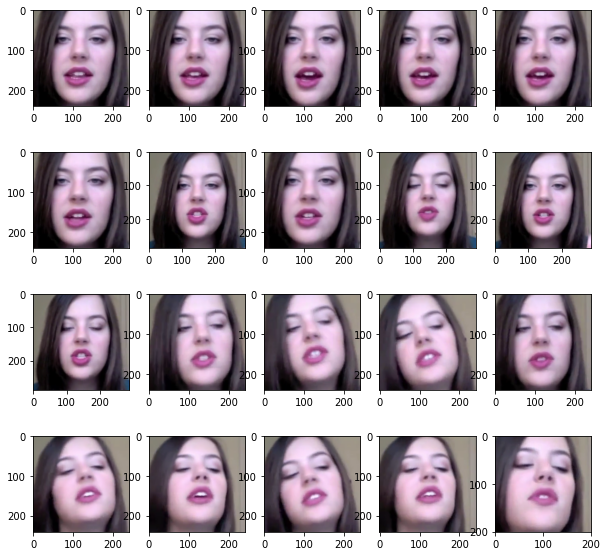

In [ ]:
show_samples(split_name="train", category='original')

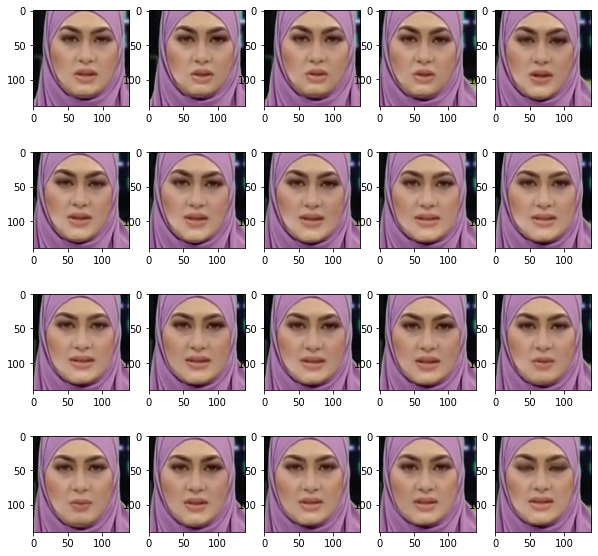

In [ ]:
show_samples(split_name="cv", category='Deepfakes')

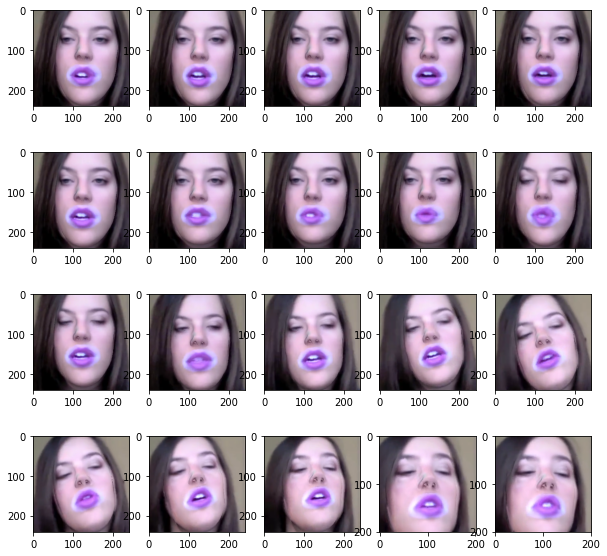

In [ ]:
show_samples(split_name="train", category='Face2Face')

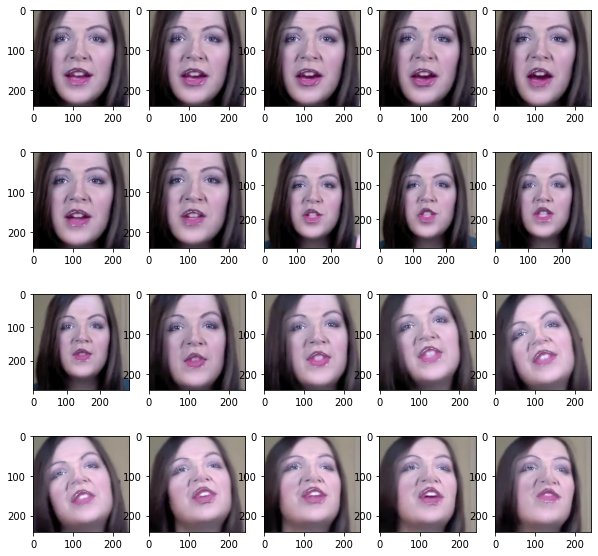

In [ ]:
show_samples(split_name="train", category='FaceSwap')

### Data Preprocessing and storing

1. Shuffle the videos 
2. Read the face cropped images and resizing to 299X299
3. Assigning class label to every image 1 or 0 (Fake =1 and Real =0)
4. Preprocessing the data and pickiling

In [ ]:
#Created to shuffle the videos
train_=[]
for ind,i in enumerate(train):
    for j in i:
        train_.append(j+'_'+types[ind])
test_=[]
for ind,i in enumerate(test):
    for j in i:
        test_.append(j+'_'+types[ind])
        
cv_=[]
for ind,i in enumerate(cv):
    for j in i:
        cv_.append(j+'_'+types[ind])

In [ ]:
TRAIN_DATADIR = raw_data_path+"Data/train"
TEST_DATADIR = raw_data_path+"Data/test"
CV_DATADIR = raw_data_path+"Data/cv"
#CLASSES = ["original", "Deepfakes","FaceSwap","Face2Face"]

In [ ]:
def create_data(DATADIR,shuffled_list):
    """
    Expects Data Directory and suffled videos list
    and will returns list of image arrays and its class label (1 or 0)
    return X,y => image_arrays, class_labels
    """
    data = []
    for name in shuffled_list: 
        label = name.split('_')[-1] 
        class_num = 0
        folder_name = name.split('_')[0]
        #seq = os.listdir(DATADIR+'/'+name.split('_')[-1])
        if len(name.split('_'))==3:
            class_num=1
            folder_name = name.split('_')[0]+'_'+name.split('_')[1]
        files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
        path = DATADIR+'/'+label+'/'+folder_name
        files.sort(key=lambda x: os.path.getmtime(DATADIR+'/'+label+'/'+folder_name+'/'+x))     
        for img in tqdm(files):           
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (299, 299))
                data.append([new_array, class_num])
            except Exception as e:
                print(str(e))
            
    print("Data gathering completed......\n Separating features and class lables")
    X = []
    y = []
    for row in tqdm(data):
        X.append(row[0])
        y.append(row[1])
    X = np.array(X).reshape(-1, 299, 299, 3)
    return X,y

In [ ]:
np.random.shuffle(train_)
X_train,Y_train = create_data(DATADIR=TRAIN_DATADIR,shuffled_list=train_)


Data gathering completed......
 Separating features and class lables


In [ ]:
np.random.shuffle(test_)

X_test,Y_test = create_data(DATADIR=TEST_DATADIR,shuffled_list=test_)


Data gathering completed......
 Separating features and class lables


In [ ]:
X_cv,Y_cv = create_data(DATADIR=CV_DATADIR,shuffled_list=cv_)


Data gathering completed......
 Separating features and class lables


In [ ]:
X_train = preprocess_input(X_train)
X_cv = preprocess_input(X_cv)
X_test = preprocess_input(X_test)

Save the prepropessed dataset. We just need to load it when we use it next time

In [ ]:
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c23/'



joblib.dump(X_train, model_path+'x_train.pkl')
joblib.dump(X_test, model_path+'x_test.pkl')
joblib.dump(Y_test, model_path+'y_test.pkl')
joblib.dump(Y_train, model_path+'y_train.pkl')
joblib.dump(X_cv, model_path+'x_cv.pkl')
joblib.dump(Y_cv, model_path+'y_cv.pkl')



# joblib.dump(X_train, 'x_train.pkl')
# joblib.dump(X_test, 'x_test.pkl')
# joblib.dump(Y_test, 'y_test.pkl')
# joblib.dump(Y_train, 'y_train.pkl')
# joblib.dump(X_cv, 'x_cv.pkl')
# joblib.dump(Y_cv, 'y_cv.pkl')

['/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c23/y_cv.pkl']

## Modeling


In [ ]:
import keras
import tensorflow as tf
from keras import layers,Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm_notebook as tqdm
import warnings
import keras.backend as K
import random
warnings.filterwarnings('ignore')


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading already preprocessed files.   RAW video
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/'
x_test=joblib.load(model_path+'x_test.pkl')
x_train=joblib.load(model_path+'x_train.pkl')
y_test=joblib.load(model_path+'y_test.pkl')
y_train=joblib.load(model_path+'y_train.pkl')
y_cv=joblib.load(model_path+'y_cv.pkl')
x_cv=joblib.load(model_path+'x_cv.pkl')

In [ ]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

Shape of Train data (7675, 299, 299, 3)
Shape of Cv data (505, 299, 299, 3)
Shape of Test data (2020, 299, 299, 3)


In [ ]:
Y_train= to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

### Xception Network

In [ ]:
#Greedy Layer-Wise Pretraining Learned from : https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/
# 1. Pre-training the network with train data on initilizing the "imagenet" weights with "include_top=False"
# 2. After training 3 epochs remove the top most layer
# 3. Now add similar top layer and again train and validate

Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )

#Xception_initial=tf.keras.applications.VGG16(include_top=False,
#                  weights='imagenet',
#                  input_shape=(299,299,3),pooling ='avg',
#                  )
#from tensorflow.keras.applications import InceptionResNetV2
#Xception_initial=InceptionResNetV2(include_top=False,
#                  weights='imagenet',
#                  input_shape=(299,299,3),pooling ='avg',
#                  )

for layer in Xception_initial.layers:
    layer.trainable = True

# Top Model Block
x = Xception_initial.output
# x = GlobalAveragePooling2D()(x)
predicted = Dense(2,activation ='softmax')(x)

model_pretrain = Model(inputs = Xception_initial.input,outputs = predicted)
model_pretrain.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

print(x_train.shape)
pretraining_Xception=model_pretrain.fit(x=x_train, y=Y_train, 
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

# Keras: vverbose(value 1) in model.fit hows less training data?

# Everything is as expected here. 18754 is not the number of training data. 
# This is the number of steps to complete one epoch. 
# The whole training data breaks into a number of groups and each group is called a batch. 
# The default batch_size is 32. 
# This means, your whole training data will be N number of groups where each group contains 32 training data.
# So what will be the size of N?
# Simple, number of steps (N) = total_training_data/batch_size.
# Now you can calculate by yourself.
# Btw, this batch is being used because your memory is limited and you can't load the whole training data into your GPU memory. 
# You can change the batch size depending on your memory size.


(7675, 299, 299, 3)
Epoch 1/3
240/240 [==============================] - 174s 704ms/step - loss: 0.1044 - accuracy: 0.9562
Epoch 2/3
240/240 [==============================] - 169s 703ms/step - loss: 0.0050 - accuracy: 0.9981
Epoch 3/3
240/240 [==============================] - 169s 703ms/step - loss: 0.0049 - accuracy: 0.9985


In [ ]:
model_pretrain.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
model_pretrain.layers.pop() # Removing topmost layer
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [ ]:
for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
x= Dense(64,activation ='relu')(x)
x = Dropout(0.7)(x)
x= Dense(64,activation ='relu')(x)
x = Dropout(0.7)(x)
x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune1 = Model(inputs = model_pretrain.input, outputs = predicted)
model_finetune1.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

model_finetune1.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
finetuning1_XceptionNet=model_finetune1.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv),
                      callbacks=[tensorboard]
                     )

Epoch 1/15
480/480 [==============================] - 44s 85ms/step - loss: 0.8980 - accuracy: 0.5424 - val_loss: 0.1972 - val_accuracy: 0.9822
Epoch 2/15
480/480 [==============================] - 39s 80ms/step - loss: 0.2977 - accuracy: 0.8830 - val_loss: 0.0842 - val_accuracy: 0.9822
Epoch 3/15
480/480 [==============================] - 38s 80ms/step - loss: 0.1590 - accuracy: 0.9492 - val_loss: 0.0669 - val_accuracy: 0.9822
Epoch 4/15
480/480 [==============================] - 38s 80ms/step - loss: 0.1024 - accuracy: 0.9723 - val_loss: 0.0611 - val_accuracy: 0.9842
Epoch 5/15
480/480 [==============================] - 38s 80ms/step - loss: 0.0827 - accuracy: 0.9782 - val_loss: 0.0614 - val_accuracy: 0.9842
Epoch 6/15
480/480 [==============================] - 38s 80ms/step - loss: 0.0641 - accuracy: 0.9827 - val_loss: 0.0648 - val_accuracy: 0.9822
Epoch 7/15
480/480 [==============================] - 38s 80ms/step - loss: 0.0513 - accuracy: 0.9860 - val_loss: 0.0681 - val_accuracy:

In [ ]:
model_finetune1.save("model_finetuned_xception.hdf5")
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/'
model_finetune1.save(model_path+"model_finetuned_xception.hdf5")


In [ ]:
model_pretrain.evaluate(x_train,Y_train)
model_pretrain.evaluate(x_cv,Y_cv)
model_pretrain.evaluate(x_test,Y_test)

64/64 [==============================] - 9s 133ms/step - loss: 0.1379 - accuracy: 0.9604


[0.1379360854625702, 0.9603960514068604]

In [ ]:
model_finetune1.evaluate(x_train,Y_train)
model_finetune1.evaluate(x_cv,Y_cv)
model_finetune1.evaluate(x_test,Y_test)

64/64 [==============================] - 9s 133ms/step - loss: 0.2089 - accuracy: 0.9658


[0.20891107618808746, 0.9658415913581848]

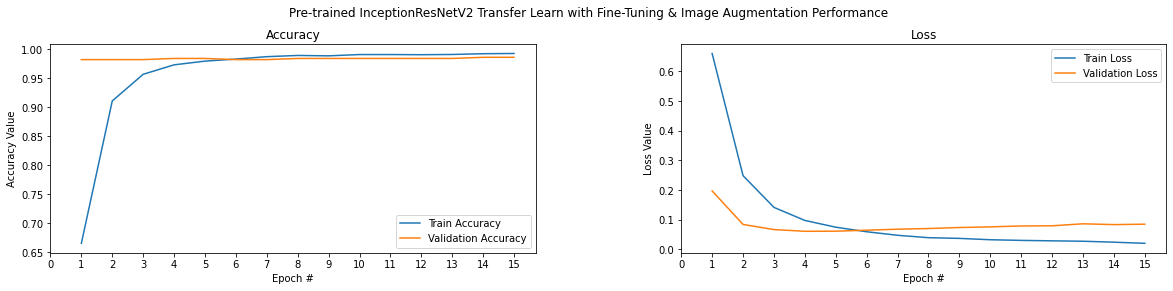

In [ ]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained Xception Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 15
epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, finetuning1_XceptionNet.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, finetuning1_XceptionNet.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, finetuning1_XceptionNet.history['loss'], label='Train Loss')
ax2.plot(epoch_list, finetuning1_XceptionNet.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Research on compressed video(c23)

In [ ]:
# Loading already preprocessed files.   RAW video
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c23/'
x_test=joblib.load(model_path+'x_test.pkl')
x_train=joblib.load(model_path+'x_train.pkl')
y_test=joblib.load(model_path+'y_test.pkl')
y_train=joblib.load(model_path+'y_train.pkl')
y_cv=joblib.load(model_path+'y_cv.pkl')
x_cv=joblib.load(model_path+'x_cv.pkl')

In [ ]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

Shape of Train data (7675, 299, 299, 3)
Shape of Cv data (505, 299, 299, 3)
Shape of Test data (2019, 299, 299, 3)


In [ ]:
Y_train= to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

In [ ]:
Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )

for layer in Xception_initial.layers:
    layer.trainable = True

# Top Model Block
x = Xception_initial.output
# x = GlobalAveragePooling2D()(x)
predicted = Dense(2,activation ='softmax')(x)

model_pretrain = Model(inputs = Xception_initial.input,outputs = predicted)
model_pretrain.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

print(x_train.shape)
pretraining_Xception=model_pretrain.fit(x=x_train, y=Y_train,validation_data=(x_cv, Y_cv),
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

(7675, 299, 299, 3)
Epoch 1/3
240/240 [==============================] - 177s 718ms/step - loss: 0.1649 - accuracy: 0.9281 - val_loss: 4.7870 - val_accuracy: 0.5901
Epoch 2/3
240/240 [==============================] - 170s 710ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 5.7235 - val_accuracy: 0.5386
Epoch 3/3
 24/240 [==>...........................] - ETA: 2:31 - loss: 0.0020 - accuracy: 0.9990

In [ ]:
model_pretrain.layers.pop() # Removing topmost layer
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [ ]:
for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
x= Dense(64,activation ='relu')(x)
x = Dropout(0.6)(x)
x= Dense(64,activation ='relu')(x)
x = Dropout(0.6)(x)
x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune2 = Model(inputs = model_pretrain.input, outputs = predicted)
model_finetune2.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

finetuning2_XceptionNet=model_finetune2.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv),
                      callbacks=[tensorboard]
                     )

In [ ]:
model_finetune2.save("model_finetuned_xception2.hdf5")
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c23/'
model_finetune2.save(model_path+"model_finetuned_xception2.hdf5")

In [ ]:
model_pretrain.evaluate(x_train,Y_train)
model_pretrain.evaluate(x_cv,Y_cv)
model_pretrain.evaluate(x_test,Y_test)

In [ ]:
model_finetune2.evaluate(x_train,Y_train)
model_finetune2.evaluate(x_cv,Y_cv)
model_finetune2.evaluate(x_test,Y_test)

64/64 [==============================] - 9s 133ms/step - loss: 5.1247 - accuracy: 0.5334


[5.124680995941162, 0.5334323644638062]

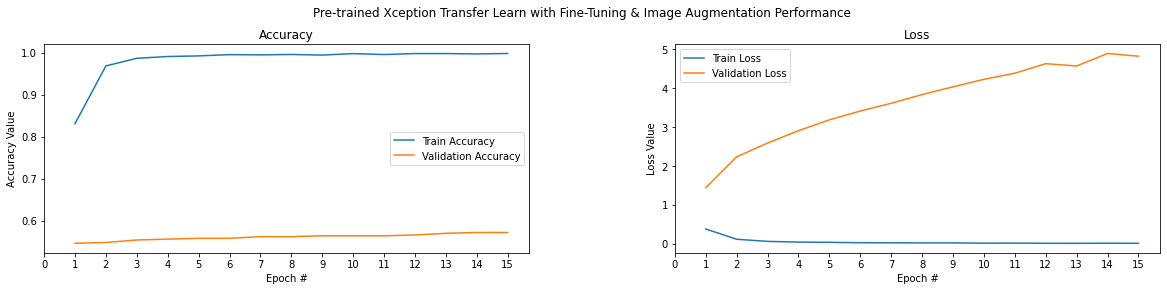

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained Xception Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 15
epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, finetuning2_XceptionNet.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, finetuning2_XceptionNet.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, finetuning2_XceptionNet.history['loss'], label='Train Loss')
ax2.plot(epoch_list, finetuning2_XceptionNet.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Research on compressed video(c40)

In [ ]:
# Loading already preprocessed files.   RAW video
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c40/'
x_test=joblib.load(model_path+'x_test.pkl')
x_train=joblib.load(model_path+'x_train.pkl')
y_test=joblib.load(model_path+'y_test.pkl')
y_train=joblib.load(model_path+'y_train.pkl')
y_cv=joblib.load(model_path+'y_cv.pkl')
x_cv=joblib.load(model_path+'x_cv.pkl')

In [ ]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

In [ ]:
Y_train= to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

In [ ]:
Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )

for layer in Xception_initial.layers:
    layer.trainable = True

# Top Model Block
x = Xception_initial.output
# x = GlobalAveragePooling2D()(x)
predicted = Dense(2,activation ='softmax')(x)

model_pretrain = Model(inputs = Xception_initial.input,outputs = predicted)
model_pretrain.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

print(x_train.shape)
pretraining_Xception=model_pretrain.fit(x=x_train, y=Y_train,
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

In [ ]:
model_pretrain.layers.pop() # Removing topmost layer
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [ ]:
for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
x= Dense(64,activation ='relu')(x)
x = Dropout(0.6)(x)
x= Dense(64,activation ='relu')(x)
x = Dropout(0.6)(x)
x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune3 = Model(inputs = model_pretrain.input, outputs = predicted)
model_finetune3.compile(loss=tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
          metrics=['accuracy'])

finetuning3_XceptionNet=model_finetune3.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv),
                      callbacks=[tensorboard]
                     )

In [ ]:
model_finetune3.save("model_finetuned_xception3.hdf5")
model_path='/content/drive/MyDrive/DL_Project/Detection-of-face-Manipulated-videos/Model/c40/'
model_finetune3.save(model_path+"model_finetuned_xception3.hdf5")

In [ ]:
model_pretrain.evaluate(x_train,Y_train)
model_pretrain.evaluate(x_cv,Y_cv)
model_pretrain.evaluate(x_test,Y_test)

In [ ]:
model_finetune3.evaluate(x_train,Y_train)
model_finetune3.evaluate(x_cv,Y_cv)
model_finetune3.evaluate(x_test,Y_test)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained Xception Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

EPOCHS = 15
epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, finetuning3_XceptionNet.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, finetuning3_XceptionNet.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, finetuning3_XceptionNet.history['loss'], label='Train Loss')
ax2.plot(epoch_list, finetuning3_XceptionNet.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")